In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, accuracy_score, precision_score, recall_score, f1_score, top_k_accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from imblearn.metrics import geometric_mean_score
import json
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
import matplotlib.transforms as mtrans
from matplotlib.lines import Line2D
import warnings
warnings.simplefilter("ignore")

In [2]:
with open('DDR-dataset/DR_grading/Predictions/resnet50_preds.json') as f:
    resnet50_preds = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/resnet152_preds.json') as f:
    resnet152_preds = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/vgg16_preds.json') as f:
    vgg16_preds = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/vgg19_preds.json') as f:
    vgg19_preds = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/eff_b0_preds.json') as f:
    eff_b0_preds = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/eff_b4_preds.json') as f:
    eff_b4_preds = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/eff_b7_preds.json') as f:
    eff_b7_preds = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/densenet121_preds.json') as f:
    densenet121_preds = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/densenet201_preds.json') as f:
    densenet201_preds = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/xception_preds.json') as f:
    xception_preds = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/mobilenet_preds.json') as f:
    mobilenet_preds = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/inception_v3_preds.json') as f:
    inception_v3_preds = json.load(f)  

with open('DDR-dataset/DR_grading/Predictions/all_labels.json') as f:
    all_labels = json.load(f)



with open('DDR-dataset/DR_grading/Predictions/resnet50_pred_proba.json') as f:
    resnet50_pred_proba = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/resnet152_pred_proba.json') as f:
    resnet152_pred_proba = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/vgg16_pred_proba.json') as f:
    vgg16_pred_proba = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/vgg19_pred_proba.json') as f:
    vgg19_pred_proba = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/eff_b0_pred_proba.json') as f:
    eff_b0_pred_proba = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/eff_b4_pred_proba.json') as f:
    eff_b4_pred_proba = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/eff_b7_pred_proba.json') as f:
    eff_b7_pred_proba = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/densenet121_pred_proba.json') as f:
    densenet121_pred_proba = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/densenet201_pred_proba.json') as f:
    densenet201_pred_proba = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/xception_pred_proba.json') as f:
    xception_pred_proba = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/mobilenet_pred_proba.json') as f:
    mobilenet_pred_proba = json.load(f)

with open('DDR-dataset/DR_grading/Predictions/inception_v3_pred_proba.json') as f:
    inception_v3_pred_proba = json.load(f)

In [3]:
def top_k_accuracy(y_true, y_proba, k=1):
    return np.mean(np.array([y_true[i] in np.argsort(y_proba[i])[-k:] for i in range(len(y_true))]))

def calculate_specificity(conf_matrix, class_index):
    true_negatives = sum(conf_matrix[i][i] for i in range(conf_matrix.shape[0]) if i != class_index)
    false_positives = sum(conf_matrix[i][class_index] for i in range(conf_matrix.shape[0]) if i != class_index)
    return true_negatives / (true_negatives + false_positives)

def weighted_avg_specificity(true_labels, preds):
    conf_matrix = confusion_matrix(true_labels, preds)
    num_classes = len(set(true_labels))
    total_samples = len(true_labels)
    weights = [sum(1 for label in true_labels if label == i) / total_samples for i in range(num_classes)]
    weighted_specificities = [calculate_specificity(conf_matrix, class_index) * weights[class_index] for class_index in range(num_classes)]
    return sum(weighted_specificities)

results = pd.DataFrame(columns=['Model', 'OA', 'T2A', 'T3A', 'SEN', 'SPEC', 'F1', 'ER', 'PREC', 'REC', 'QWK', 'GM'])

model_names = ['Resnet-50', 'Resnet-152', 'VGG-16', 'VGG-19', 'Efficientnet-B0', 'Efficientnet-B4', 'Efficientnet-B7', 'Densenet-121', 'Densenet-201', 'Xception', 'Mobilenet', 'Inception-v3']  
models_preds_proba = {
    'Resnet-50': resnet50_pred_proba,
    'Resnet-152': resnet152_pred_proba,
    'VGG-16': vgg16_pred_proba,
    'VGG-19': vgg19_pred_proba,
    'Efficientnet-B0': eff_b0_pred_proba,
    'Efficientnet-B4': eff_b4_pred_proba,
    'Efficientnet-B7': eff_b7_pred_proba,
    'Densenet-121': densenet121_pred_proba,
    'Densenet-201': densenet201_pred_proba,
    'Xception': xception_pred_proba,
    'Mobilenet': mobilenet_pred_proba,
    'Inception-v3': inception_v3_pred_proba
}

for y_pred, model_name in zip([resnet50_preds, resnet152_preds, vgg16_preds, vgg19_preds, eff_b0_preds, eff_b4_preds, eff_b7_preds, densenet121_preds, densenet201_preds, xception_preds, mobilenet_preds, inception_v3_preds], model_names):
    
    pred_proba = models_preds_proba[model_name]

    # Calculate metrics
    accuracy = accuracy_score(all_labels, y_pred)
    precision = precision_score(all_labels, y_pred, average='weighted')
    recall = recall_score(all_labels, y_pred, average='weighted')
    f1 = f1_score(all_labels, y_pred, average='weighted')
    kappa = cohen_kappa_score(all_labels, y_pred, weights='quadratic')
    gmean = geometric_mean_score(all_labels, y_pred, average='weighted')
    specificity = weighted_avg_specificity(all_labels, y_pred)
    error_rate = 1 - accuracy
    top_2_acc = top_k_accuracy(all_labels, pred_proba, 2)
    top_3_acc = top_k_accuracy(all_labels, pred_proba, 3)

    # Add the metrics to the results DataFrame
    new_row = pd.DataFrame({
    'Model': [model_name],
    'OA': [accuracy],
    'T2A': [top_2_acc],
    'T3A': [top_3_acc],
    'SEN': [recall],
    'SPEC': [specificity], 
    'F1': [f1],
    'ER': [error_rate],
    'PREC': [precision],
    'REC': [recall],
    'QWK': [kappa],
    'GM': [gmean]
})

    results = pd.concat([results, new_row], ignore_index=True)

# Transpose the DataFrame
results = results.set_index('Model').T

In [4]:
results

Model,Resnet-50,Resnet-152,VGG-16,VGG-19,Efficientnet-B0,Efficientnet-B4,Efficientnet-B7,Densenet-121,Densenet-201,Xception,Mobilenet,Inception-v3
OA,0.849162,0.838787,0.843575,0.838787,0.833200,0.842777,0.841181,0.837989,0.846768,0.837989,0.841181,0.841181
T2A,0.936951,0.941740,0.944932,0.933759,0.943336,0.928970,0.939346,0.936951,0.944134,0.939346,0.932961,0.940942
T3A,0.984038,0.992817,0.996808,0.994413,0.988827,0.980846,0.984038,0.986433,0.988029,0.982442,0.986433,0.988827
SEN,0.849162,0.838787,0.843575,0.838787,0.833200,0.842777,0.841181,0.837989,0.846768,0.837989,0.841181,0.841181
SPEC,0.888323,0.864992,0.891405,0.876385,0.865540,0.886695,0.882416,0.887723,0.888790,0.885457,0.894952,0.890609
F1,0.832748,0.815589,0.832720,0.815903,0.814067,0.832110,0.830286,0.825433,0.835979,0.827102,0.837371,0.830848
ER,0.150838,0.161213,0.156425,0.161213,0.166800,0.157223,0.158819,0.162011,0.153232,0.162011,0.158819,0.158819
PREC,0.830385,0.818828,0.828768,0.811602,0.824749,0.829002,0.830958,0.820040,0.832177,0.821312,0.834907,0.828397
REC,0.849162,0.838787,0.843575,0.838787,0.833200,0.842777,0.841181,0.837989,0.846768,0.837989,0.841181,0.841181
QWK,0.858513,0.844021,0.869884,0.849623,0.842511,0.856365,0.851311,0.863487,0.869547,0.847427,0.864475,0.862285


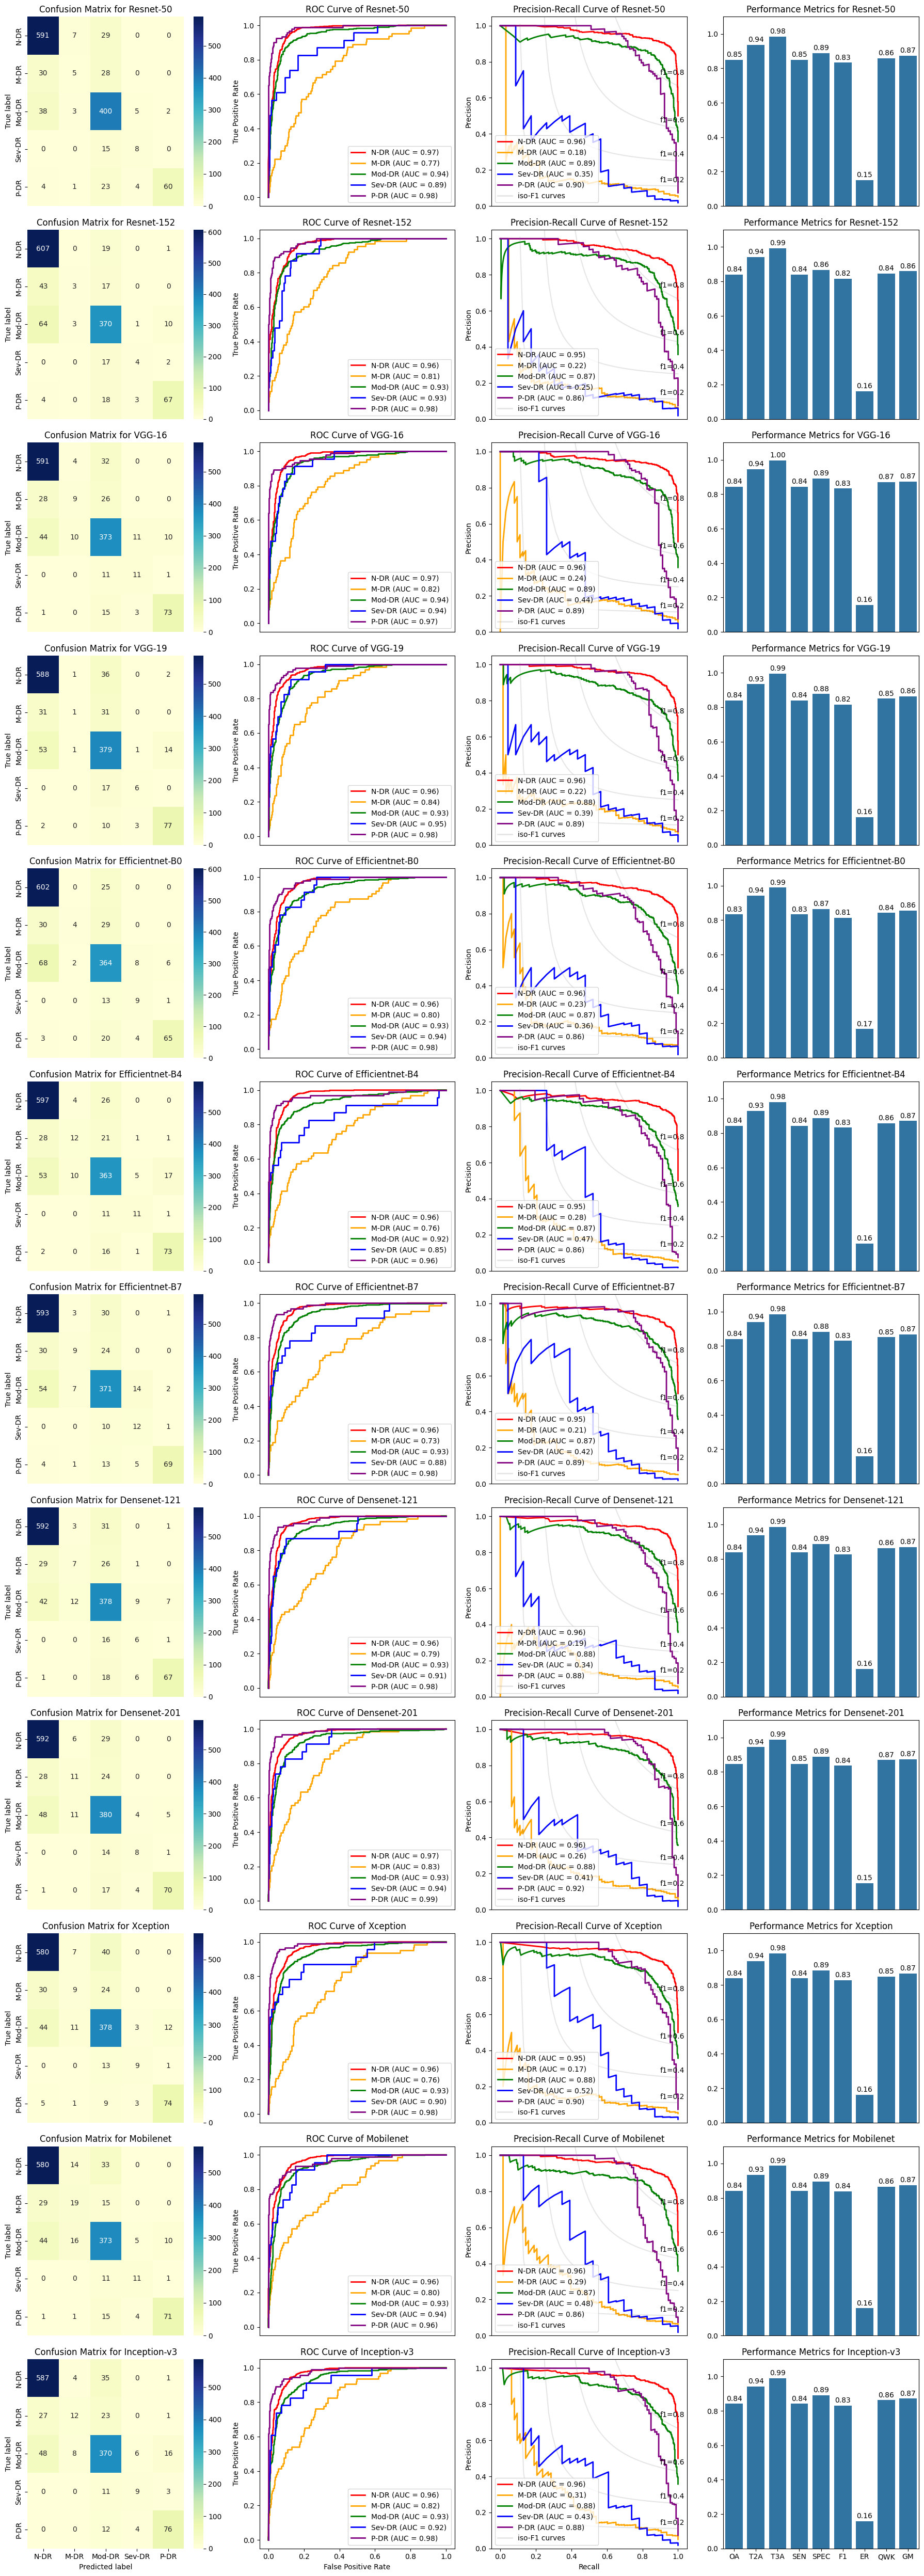

In [75]:
n_rows = 12
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 50))

# Binarize the output
y = label_binarize(all_labels, classes=[0, 1, 2, 3, 4]) 
n_classes = y.shape[1]
class_names = {0: 'N-DR', 1: 'M-DR', 2: 'Mod-DR', 3: 'Sev-DR', 4: 'P-DR'}

# CONFUSION MATRIX
for ax, y_pred, model_name in zip(axes[:,0], [resnet50_preds, resnet152_preds, vgg16_preds, vgg19_preds, eff_b0_preds, eff_b4_preds, eff_b7_preds, densenet121_preds, densenet201_preds, xception_preds, mobilenet_preds, inception_v3_preds], model_names):
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, y_pred)
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', ax=ax, xticklabels=class_names.values(), yticklabels=class_names.values())
    ax.set_title('Confusion Matrix for ' + model_name)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=90)
    # Hide x and y ticks for all but the last graph
    if model_name != model_names[-1]:
        ax.set_xticklabels([])
        # ax.set_yticklabels([])
        ax.set_xlabel('')
        # ax.set_ylabel('')
        ax.tick_params(bottom=False)  # Hide tickmarks

# ROC CURVE
for ax, y_pred, model_name in zip(axes[:,1], [resnet50_preds, resnet152_preds, vgg16_preds, vgg19_preds, eff_b0_preds, eff_b4_preds, eff_b7_preds, densenet121_preds, densenet201_preds, xception_preds, mobilenet_preds, inception_v3_preds], model_names):
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        pred_proba = np.array(models_preds_proba[model_name])
        fpr[i], tpr[i], _ = roc_curve(y[:, i], pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    colors = cycle(['red', 'orange', 'green', 'blue', 'purple'])
    for i, color in zip(range(n_classes), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw=2, label='{0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc[i]))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve of {model_name}')
    ax.legend(loc="lower right")

    # Hide x and y ticks for all but the last graph
    if model_name != model_names[-1]:
        ax.set_xticklabels([])
        # ax.set_yticklabels([])
        ax.set_xlabel('')
        # ax.set_ylabel('')
        ax.tick_params(bottom=False)  # Hide tickmarks

# PRECISION-RECALL CURVE
for ax, y_pred, model_name in zip(axes[:,2], [resnet50_preds, resnet152_preds, vgg16_preds, vgg19_preds, eff_b0_preds, eff_b4_preds, eff_b7_preds, densenet121_preds, densenet201_preds, xception_preds, mobilenet_preds, inception_v3_preds], model_names):
    precision, recall, prcurve = dict(), dict(), dict()
    for i in range(n_classes):
        pred_proba = np.array(models_preds_proba[model_name])
        precision[i], recall[i], _ = precision_recall_curve(y[:, i], pred_proba[:, i])
        prcurve[i] = average_precision_score(y[:, i], pred_proba[:, i])

    colors = cycle(['red', 'orange', 'green', 'blue', 'purple'])
    for i, color in zip(range(n_classes), colors):
        ax.plot(recall[i], precision[i], color=color, lw=2, label=f'{class_names[i]} (AUC = {prcurve[i]:0.2f})')
        
    # Add iso-F1 curves
    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        w = np.linspace(0.01, 1)
        z = f_score * w / (2 * w - f_score)
        ax.plot(w[z >= 0], z[z >= 0], color='gray', alpha=0.2)
        ax.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, z[45] + 0.02))

    # Create a Line2D object for the iso-F1 curves
    iso_f1_line = Line2D([0], [0], color='gray', alpha=0.2, lw=2, label='iso-F1 curves')
    # Get the existing legend
    handles, labels = ax.get_legend_handles_labels()
    # Add the iso-F1 curves to the legend
    handles.append(iso_f1_line)
    ax.legend(handles=handles, loc="lower left")

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve of {model_name}')
    # ax.legend(loc="lower left")
    ax.set_ylim([0.0, 1.05])

    # Hide x and y ticks for all but the last graph
    if model_name != model_names[-1]:
        ax.set_xticklabels([])
        # ax.set_yticklabels([])
        ax.set_xlabel('')
        # ax.set_ylabel('')
        ax.tick_params(bottom=False)  # Hide tickmarks

# METRICS
for ax, model_name in zip(axes[:,3], model_names):
    barplot = sns.barplot(data=results[model_name].drop(index=['PREC', 'REC']), ax=ax, )
    ax.set_title(f'Performance Metrics for {model_name}')
    ax.set_ylabel('')
    ax.set_ylim([0, 1.1])

    # Hide x and y ticks for all but the last graph
    if model_name != model_names[-1]:
        ax.set_xticklabels([])
        # ax.set_yticklabels([])
        ax.tick_params(bottom=False)  # Hide tickmarks
    
    # Add the value on top of each bar
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.2f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', xytext = (0, 7), textcoords = 'offset points')
    

plt.tight_layout()

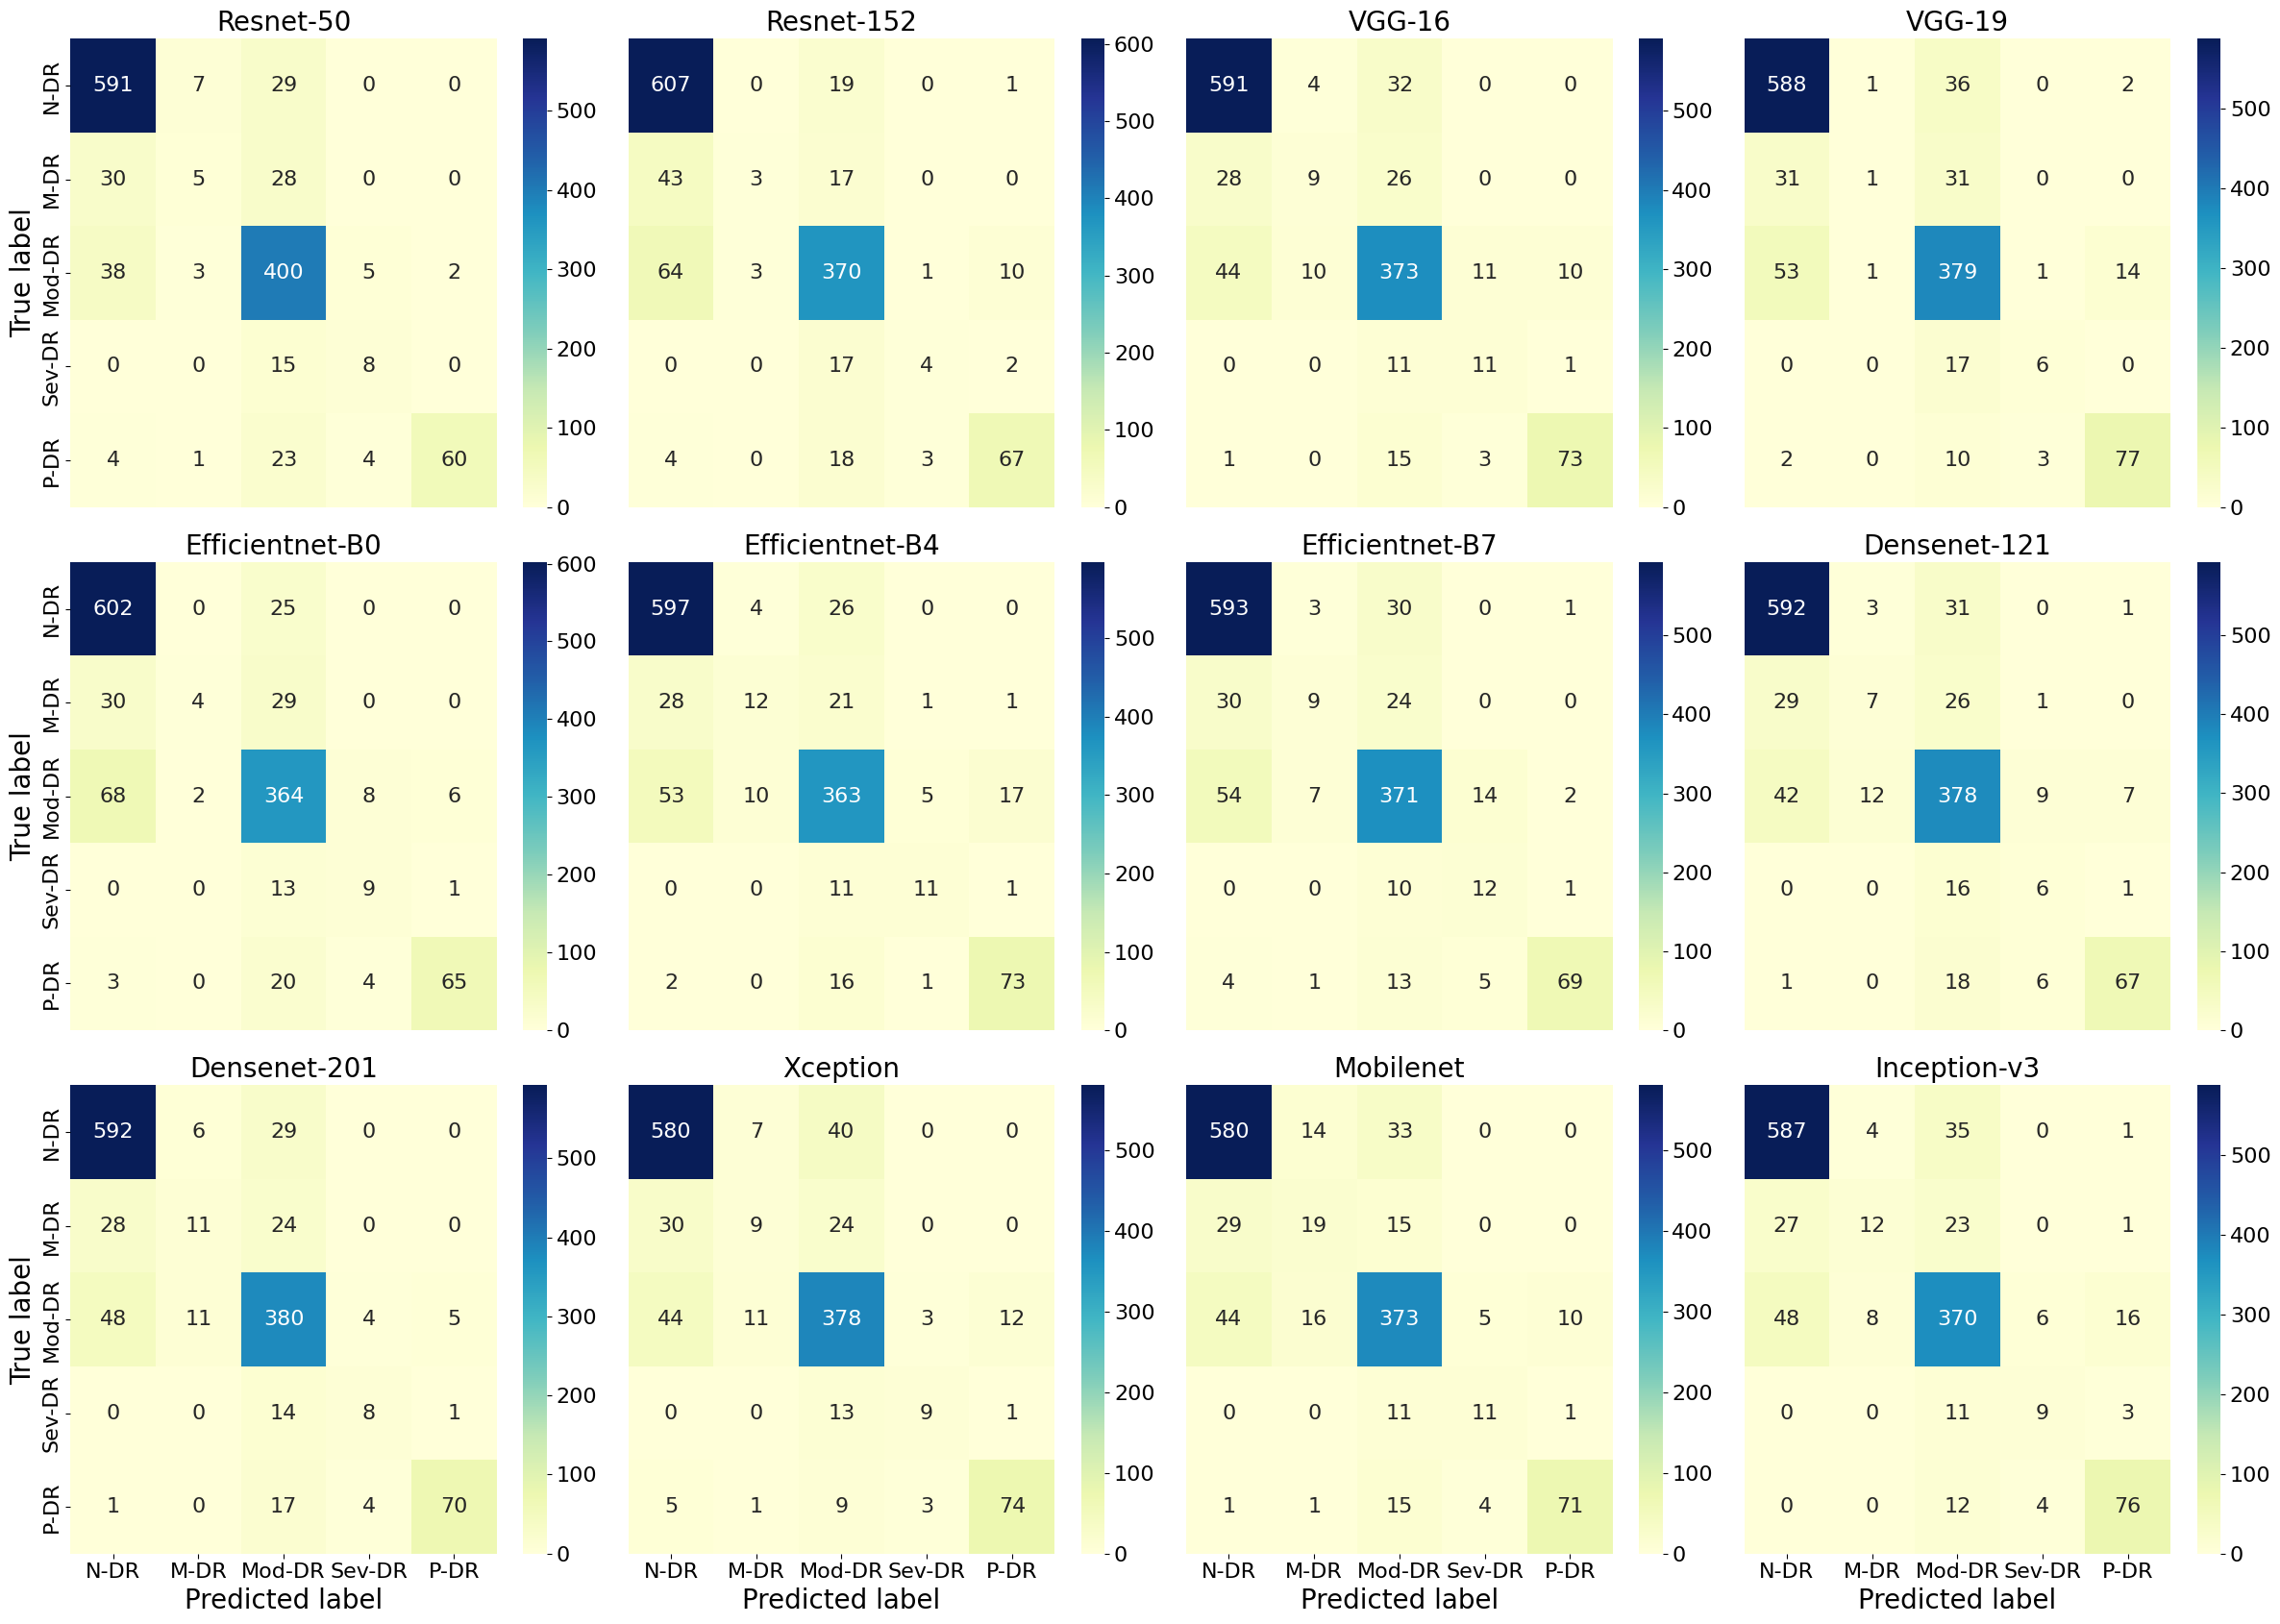

In [59]:
n_rows = 3
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 17))

# Binarize the output
y = label_binarize(all_labels, classes=[0, 1, 2, 3, 4]) 
n_classes = y.shape[1]
class_names = {0: 'N-DR', 1: 'M-DR', 2: 'Mod-DR', 3: 'Sev-DR', 4: 'P-DR'}

# CONFUSION MATRIX
for i, (ax, y_pred, model_name) in enumerate(zip(axes.flatten(), [resnet50_preds, resnet152_preds, vgg16_preds, vgg19_preds, eff_b0_preds, eff_b4_preds, eff_b7_preds, densenet121_preds, densenet201_preds, xception_preds, mobilenet_preds, inception_v3_preds], model_names)):

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, y_pred)
    # Plot confusion matrix
    heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', ax=ax, xticklabels=class_names.values(), yticklabels=class_names.values(), annot_kws={"size": 16})
    cbar = heatmap.collections[0].colorbar
    cbar.ax.yaxis.set_tick_params(labelsize=16)  # Change the font size of the colorbar labels

    ax.set_title(model_name, fontsize=20)
    # ax.set_ylabel('True label')
    # ax.set_xlabel('Predicted label')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=90)

 # Only show x-axis labels for the bottom-most subplots
    if i // n_cols == n_rows - 1:
        ax.set_xlabel('Predicted label', fontsize=20)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=12)
        ax.tick_params(bottom=True, labelsize=16)
    else:
        ax.set_xlabel('')
        ax.set_xticklabels([])
        ax.tick_params(bottom=False)
        
    # Only show y-axis labels for the left-most subplots
    if i % n_cols == 0:
        ax.set_ylabel('True label', fontsize=20)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=90, fontsize=12)
        ax.tick_params(left=True, labelsize=16)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.tick_params(left=False)

plt.tight_layout()

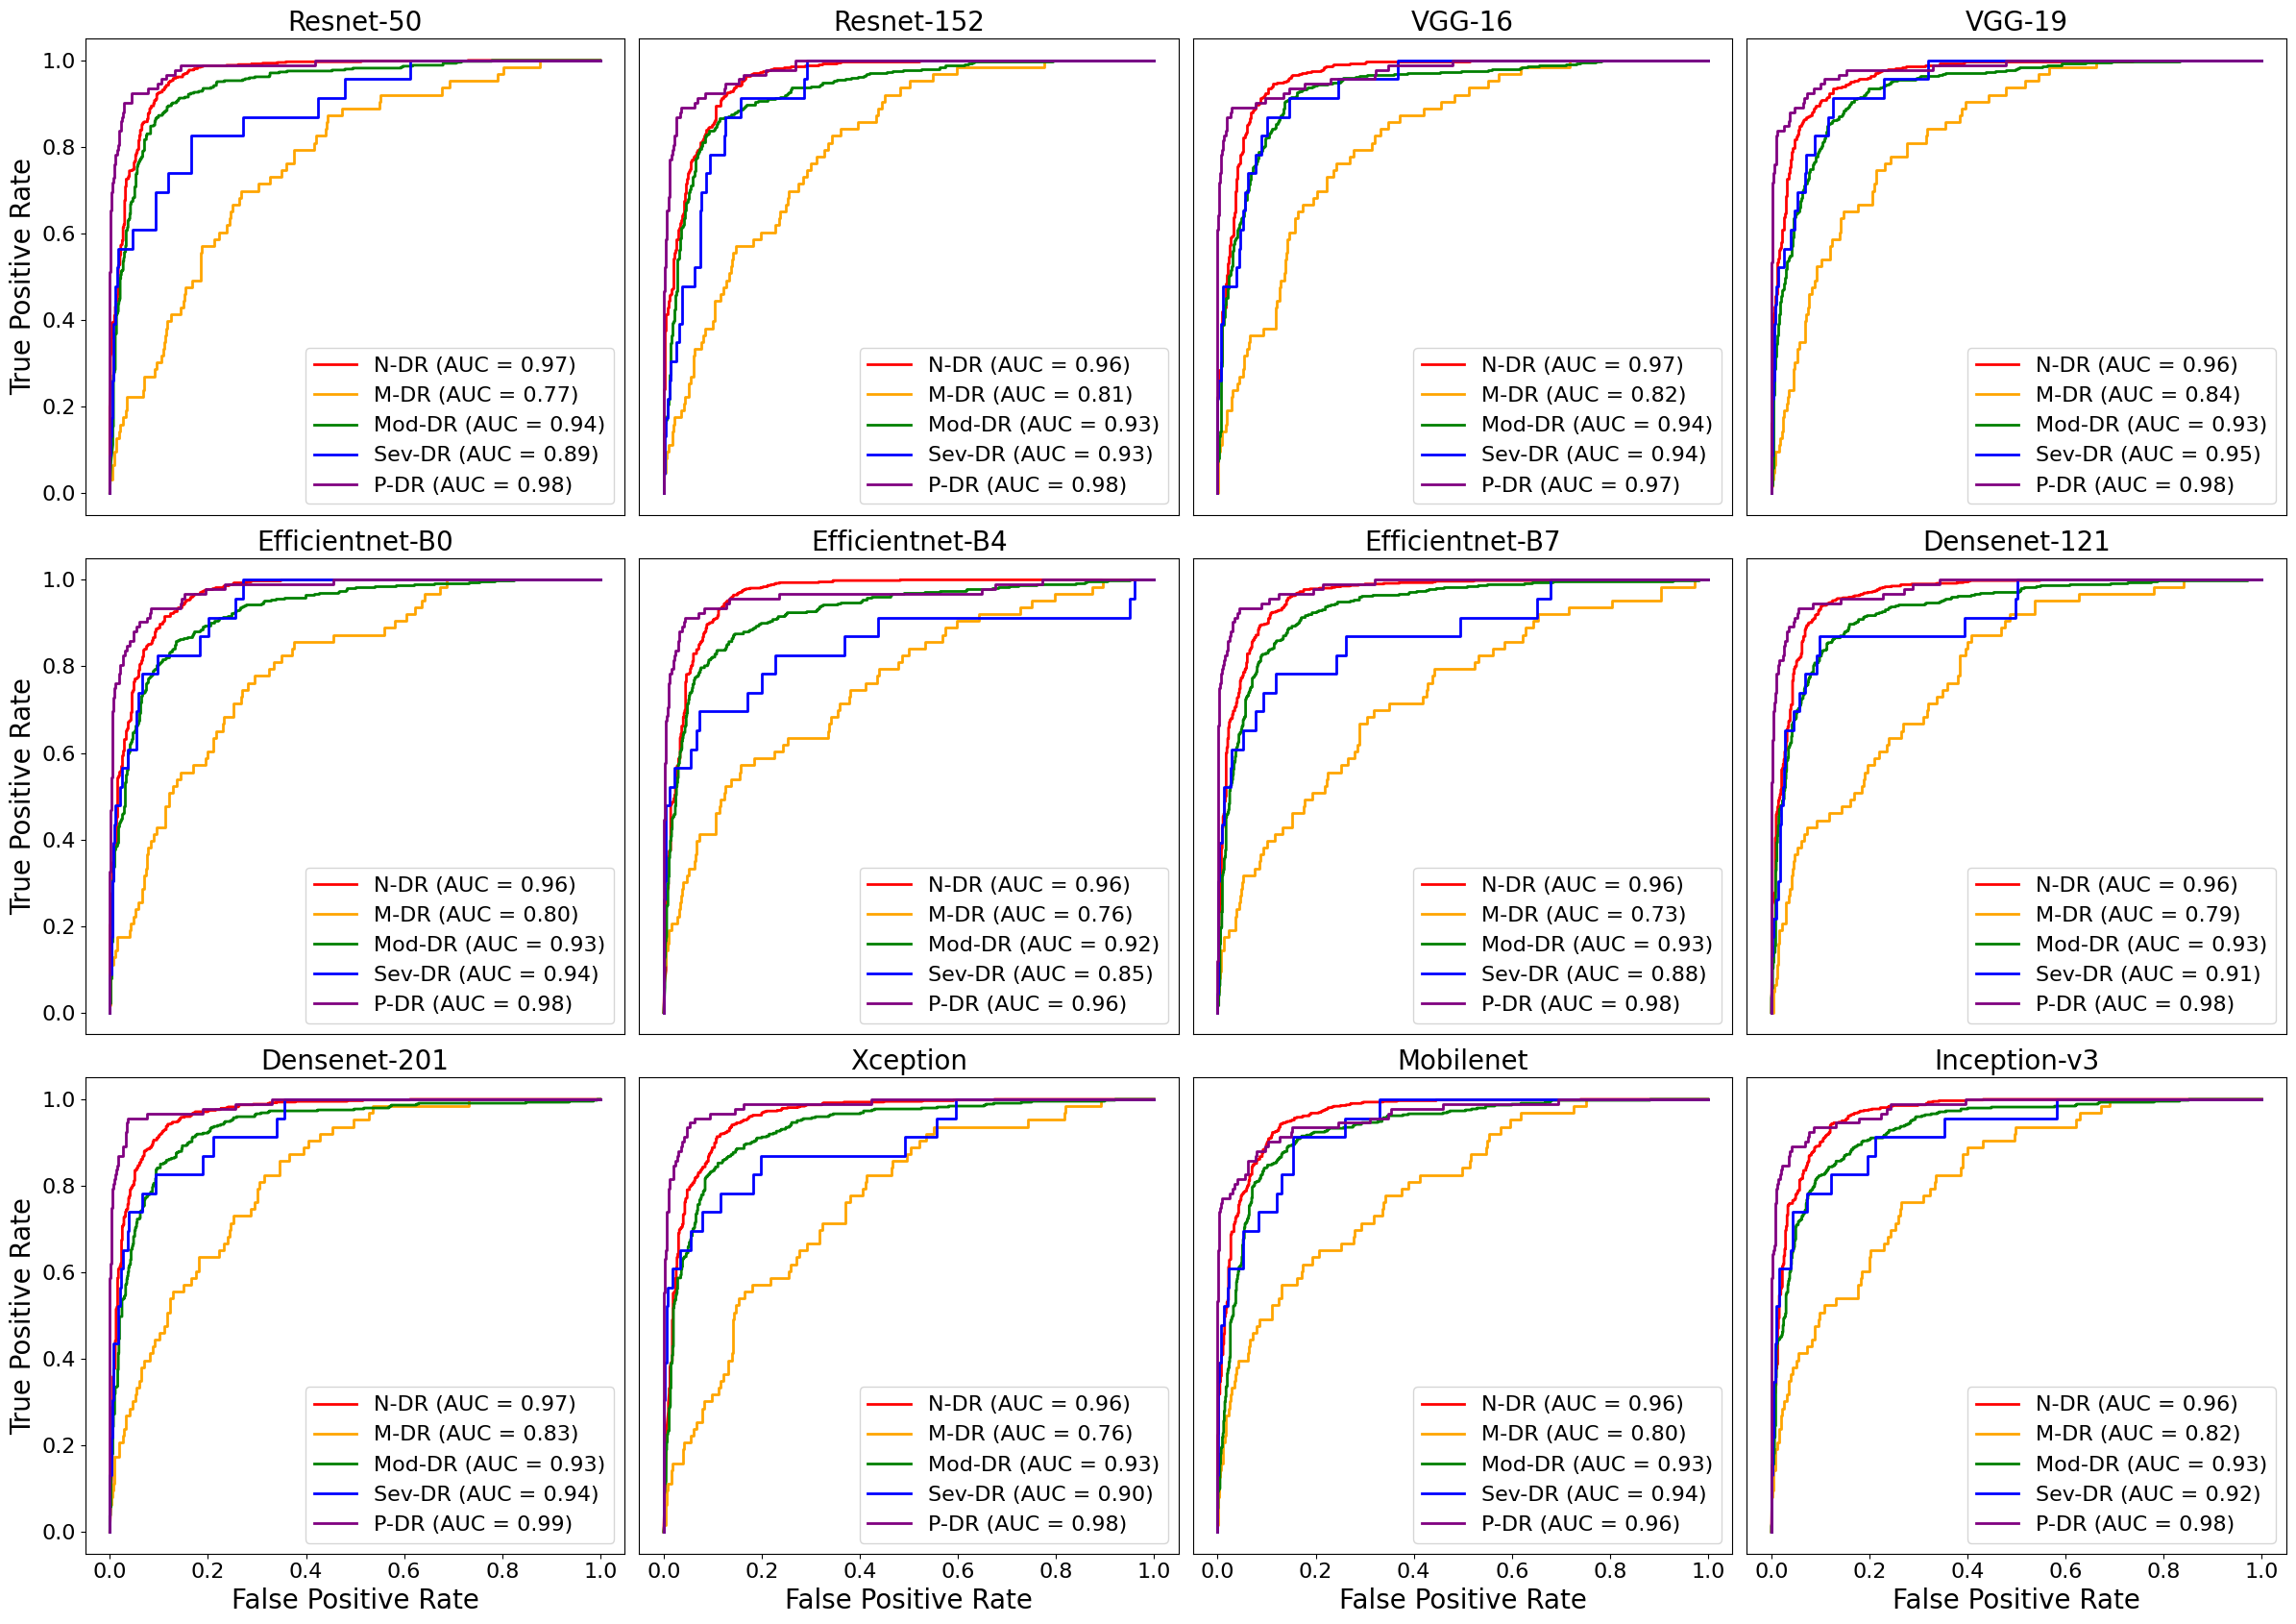

In [64]:
n_rows = 3
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 17))

# Binarize the output
y = label_binarize(all_labels, classes=[0, 1, 2, 3, 4]) 
n_classes = y.shape[1]
class_names = {0: 'N-DR', 1: 'M-DR', 2: 'Mod-DR', 3: 'Sev-DR', 4: 'P-DR'}

# ROC CURVE
for ii, (ax, y_pred, model_name) in enumerate(zip(axes.flatten(), [resnet50_preds, resnet152_preds, vgg16_preds, vgg19_preds, eff_b0_preds, eff_b4_preds, eff_b7_preds, densenet121_preds, densenet201_preds, xception_preds, mobilenet_preds, inception_v3_preds], model_names)):
    
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        pred_proba = np.array(models_preds_proba[model_name])
        fpr[i], tpr[i], _ = roc_curve(y[:, i], pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    colors = cycle(['red', 'orange', 'green', 'blue', 'purple'])
    for i, color in zip(range(n_classes), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw=2, label='{0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc[i]))
    # ax.set_xlabel('False Positive Rate')
    # ax.set_ylabel('True Positive Rate')
    ax.set_title(model_name, fontsize=20)
    ax.legend(loc="lower right", fontsize=16)

    # Only show x-axis labels for the bottom-most subplots
    if ii // n_cols == n_rows - 1:
        ax.set_xlabel('False Positive Rate', fontsize=20)
        ax.set_xticklabels(ax.get_xticklabels())
        ax.tick_params(bottom=True, labelsize=16)
    else:
        ax.set_xlabel('')
        ax.set_xticklabels([])
        ax.tick_params(bottom=False)
        
    # Only show y-axis labels for the left-most subplots
    if ii % n_cols == 0:
        ax.set_ylabel('True Positive Rate', fontsize=20)
        ax.set_yticklabels(ax.get_yticklabels())
        ax.tick_params(left=True, labelsize=16)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.tick_params(left=False)

plt.tight_layout()

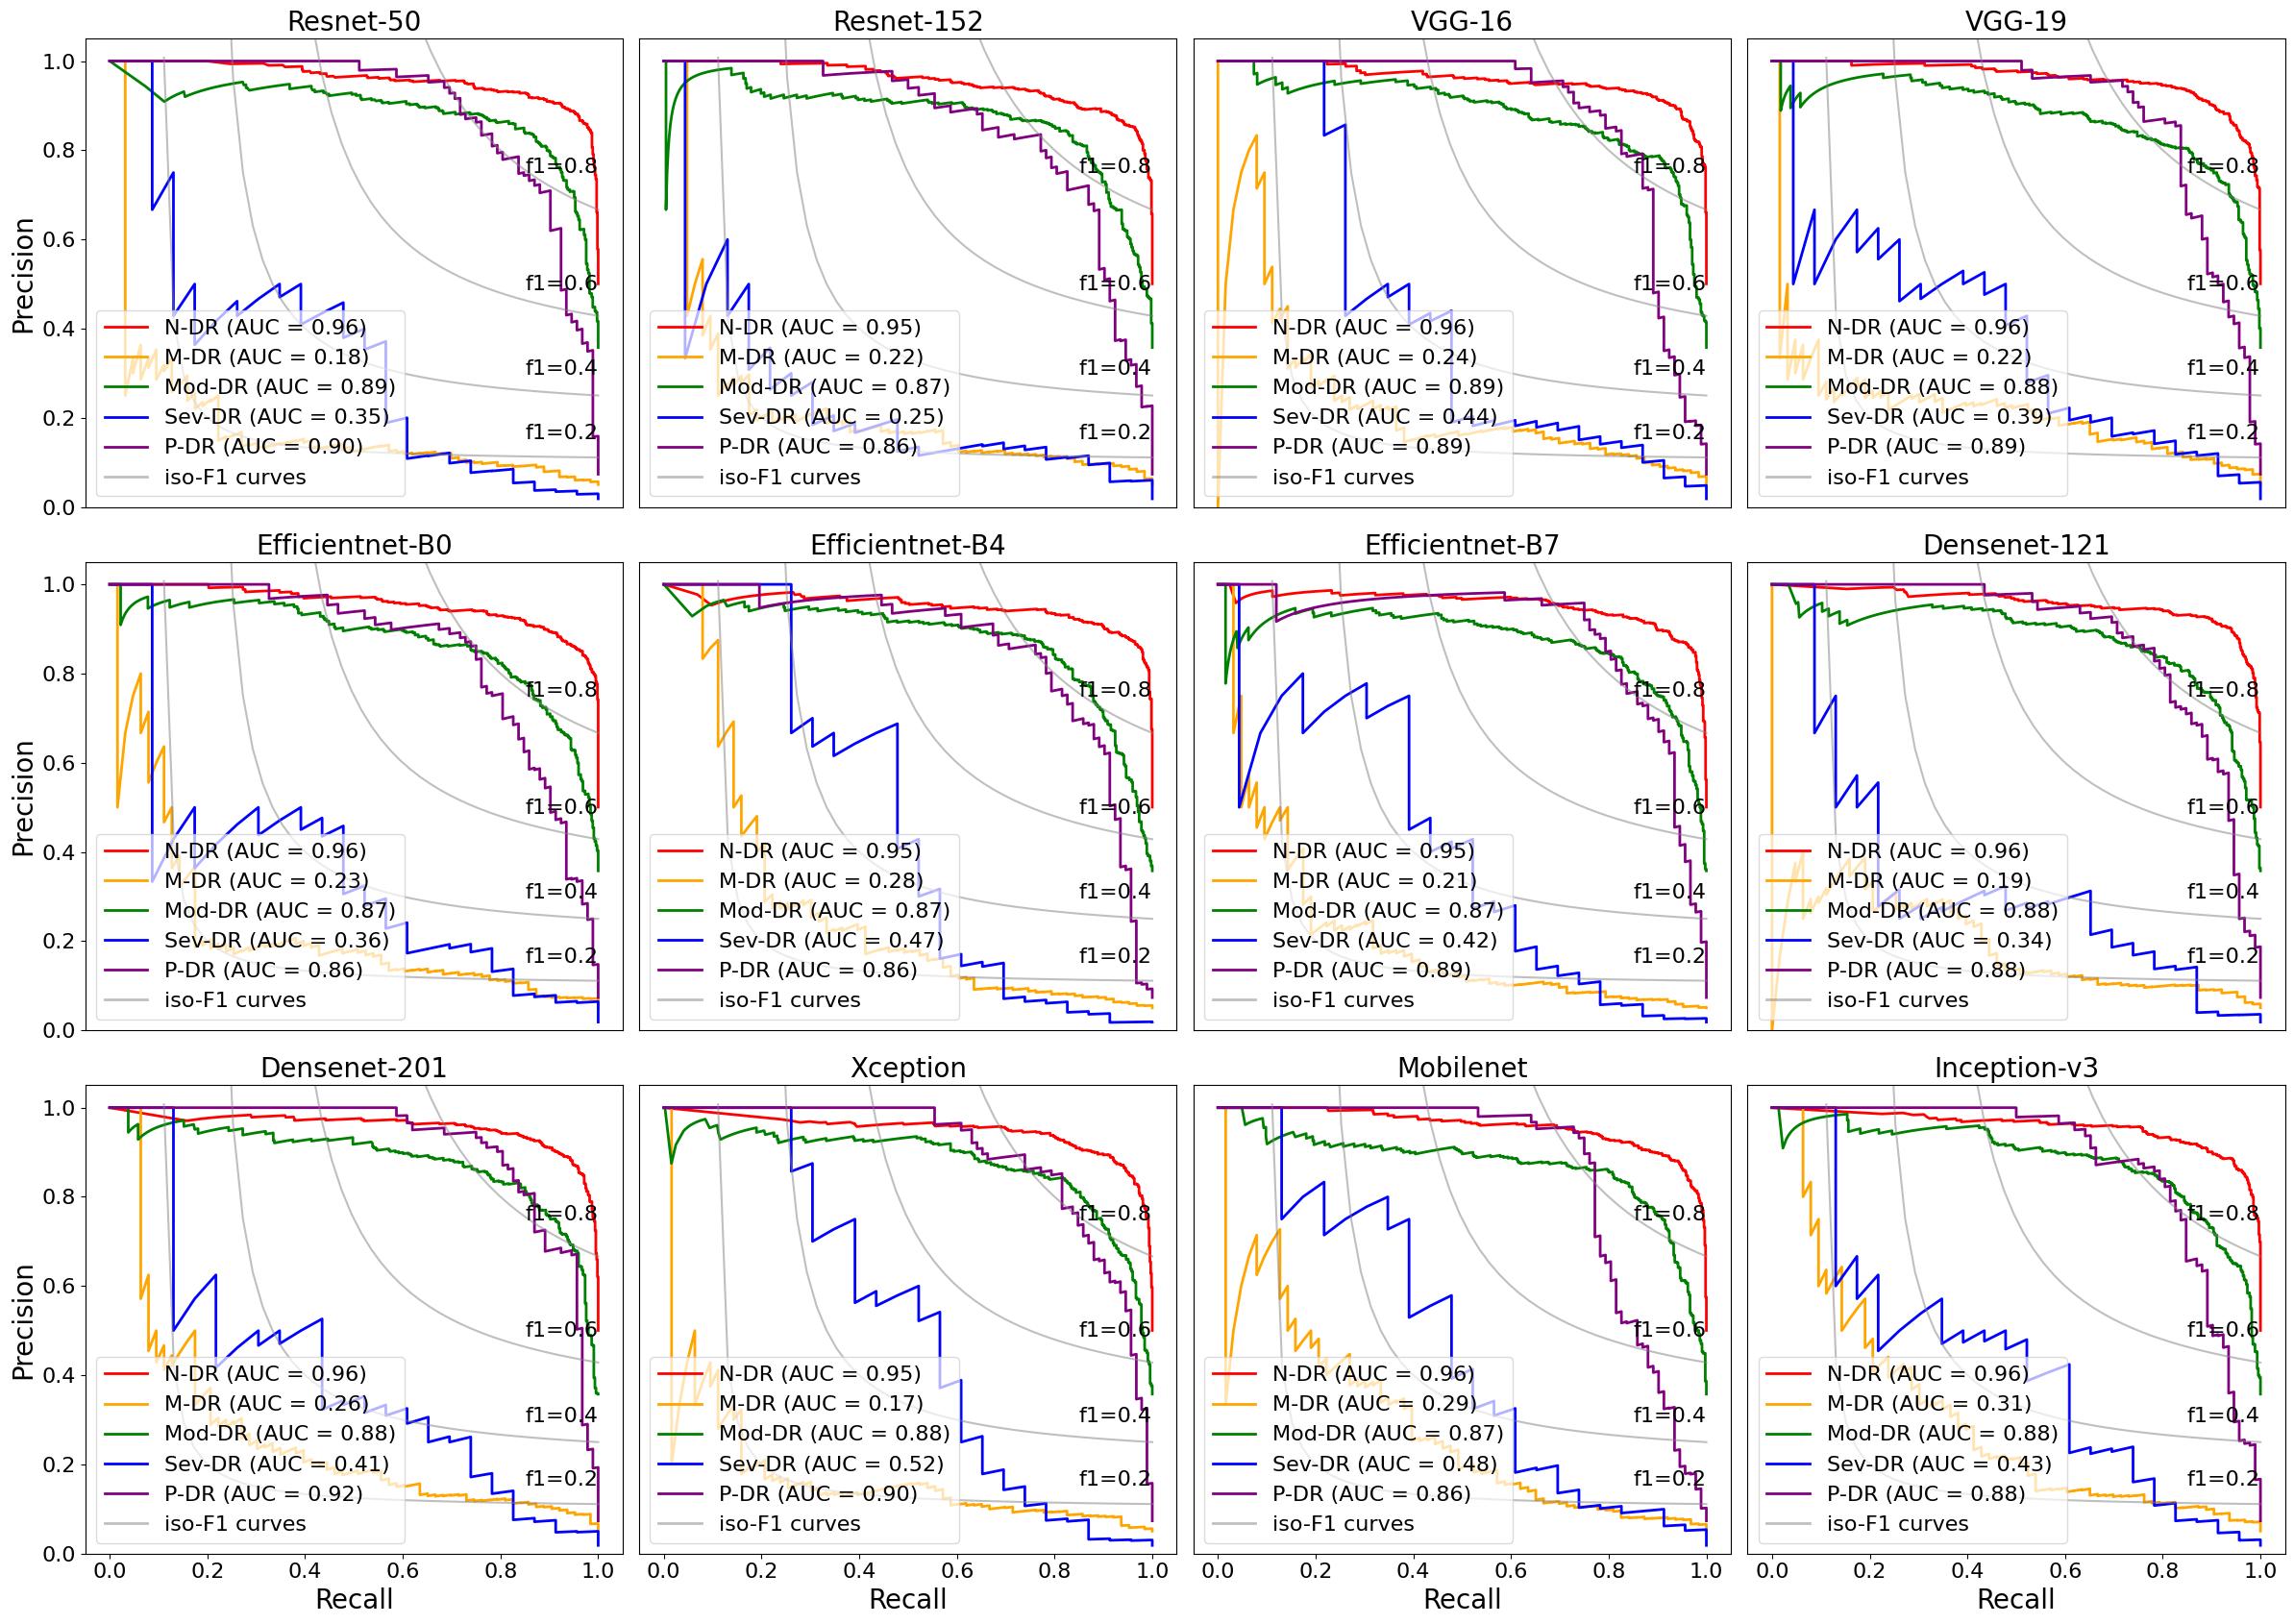

In [78]:
n_rows = 3
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 17))

# Binarize the output
y = label_binarize(all_labels, classes=[0, 1, 2, 3, 4]) 
n_classes = y.shape[1]
class_names = {0: 'N-DR', 1: 'M-DR', 2: 'Mod-DR', 3: 'Sev-DR', 4: 'P-DR'}

# PRECISION-RECALL CURVE
for ii, (ax, y_pred, model_name) in enumerate(zip(axes.flatten(), [resnet50_preds, resnet152_preds, vgg16_preds, vgg19_preds, eff_b0_preds, eff_b4_preds, eff_b7_preds, densenet121_preds, densenet201_preds, xception_preds, mobilenet_preds, inception_v3_preds], model_names)):
  
    precision, recall, prcurve = dict(), dict(), dict()
    for i in range(n_classes):
        pred_proba = np.array(models_preds_proba[model_name])
        precision[i], recall[i], _ = precision_recall_curve(y[:, i], pred_proba[:, i])
        prcurve[i] = average_precision_score(y[:, i], pred_proba[:, i])

    colors = cycle(['red', 'orange', 'green', 'blue', 'purple'])
    for i, color in zip(range(n_classes), colors):
        ax.plot(recall[i], precision[i], color=color, lw=2, label=f'{class_names[i]} (AUC = {prcurve[i]:0.2f})')
        
    # Add iso-F1 curves
    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        w = np.linspace(0.01, 1)
        z = f_score * w / (2 * w - f_score)
        ax.plot(w[z >= 0], z[z >= 0], color='gray', alpha=0.5)
        ax.annotate('f1={0:0.1f}'.format(f_score), xy=(0.85, z[45] + 0.04), fontsize=16)

    # Create a Line2D object for the iso-F1 curves
    iso_f1_line = Line2D([0], [0], color='gray', alpha=0.5, lw=2, label='iso-F1 curves')
    # Get the existing legend
    handles, labels = ax.get_legend_handles_labels()
    # Add the iso-F1 curves to the legend
    handles.append(iso_f1_line)
    ax.legend(handles=handles, loc="lower left", framealpha=0.7, fontsize=16)
    # ax.set_xlabel('Recall')
    # ax.set_ylabel('Precision')
    ax.set_title(model_name, fontsize=20)
    # ax.legend(loc="lower left")
    ax.set_ylim([0.0, 1.05])

    # Only show x-axis labels for the bottom-most subplots
    if ii // n_cols == n_rows - 1:
        ax.set_xlabel('Recall', fontsize=20)
        ax.set_xticklabels(ax.get_xticklabels())
        ax.tick_params(bottom=True, labelsize=16)
    else:
        ax.set_xlabel('')
        ax.set_xticklabels([])
        ax.tick_params(bottom=False)
        
    # Only show y-axis labels for the left-most subplots
    if ii % n_cols == 0:
        ax.set_ylabel('Precision', fontsize=20)
        ax.set_yticklabels(ax.get_yticklabels())
        ax.tick_params(left=True, labelsize=16)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.tick_params(left=False)

plt.tight_layout()

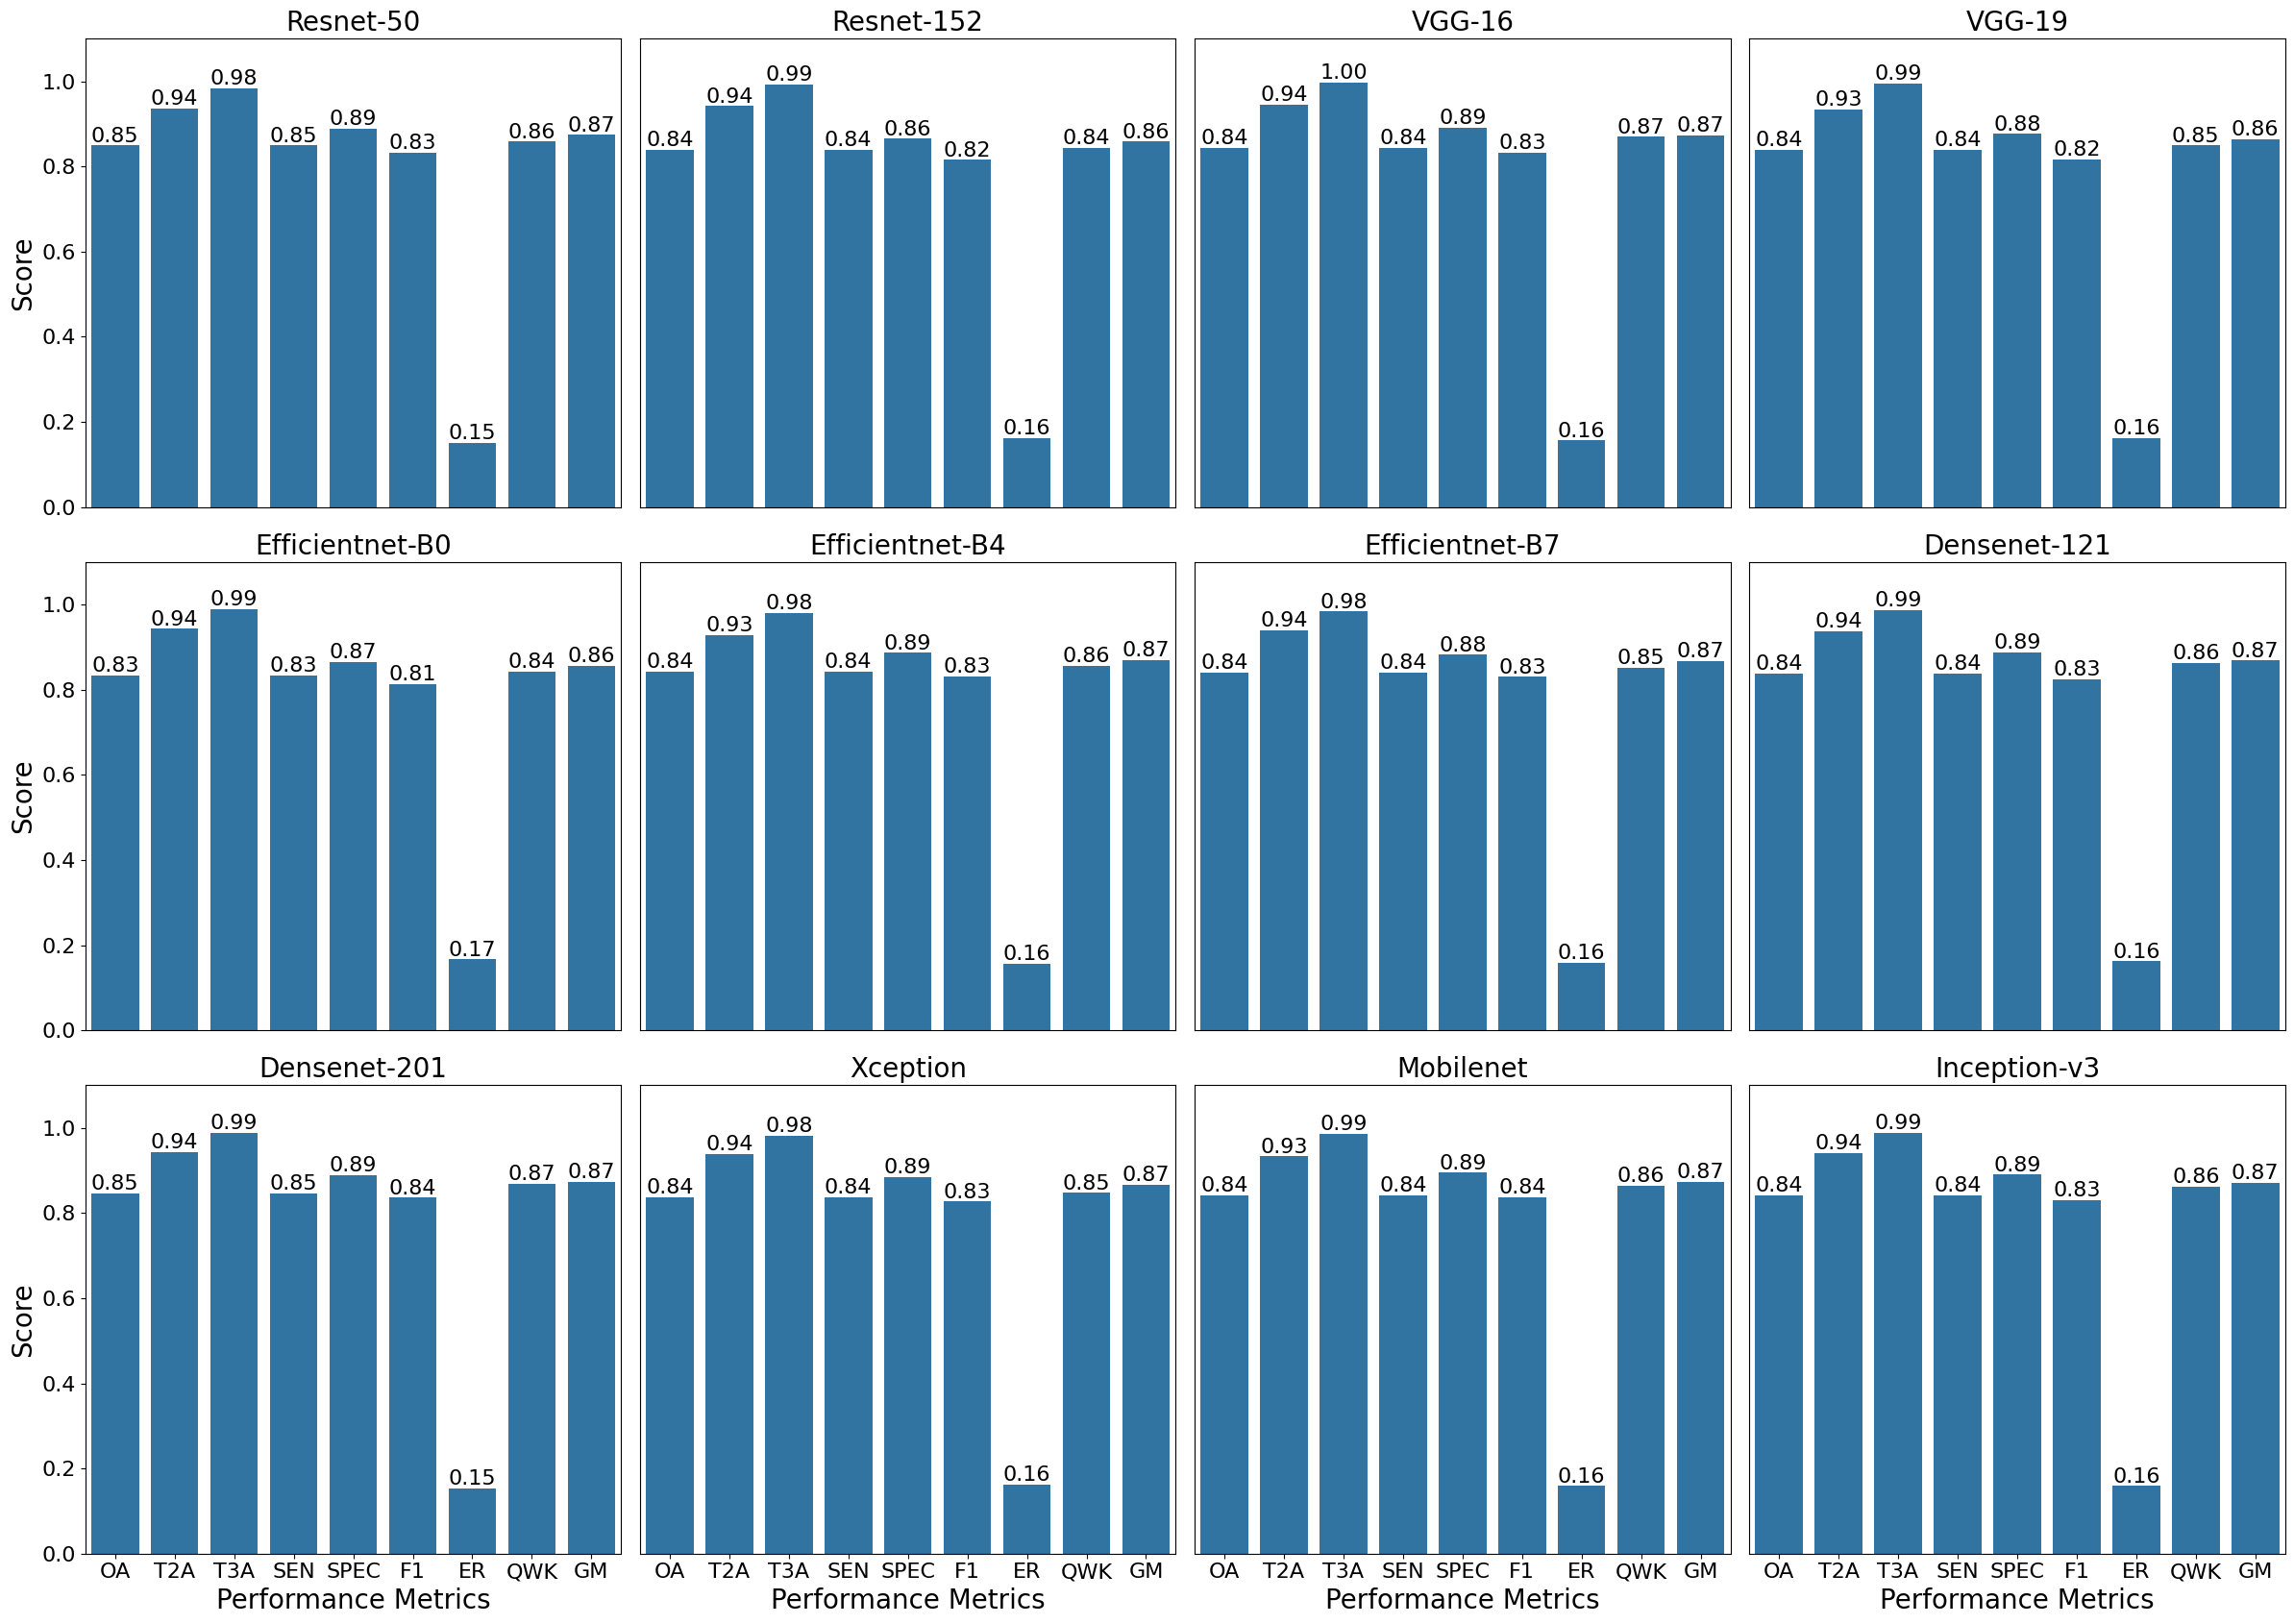

In [70]:
n_rows = 3
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 17))

# Binarize the output
y = label_binarize(all_labels, classes=[0, 1, 2, 3, 4]) 
n_classes = y.shape[1]
class_names = {0: 'N-DR', 1: 'M-DR', 2: 'Mod-DR', 3: 'Sev-DR', 4: 'P-DR'}

# PERFORMANCE METRICS
for ii, (ax, model_name) in enumerate(zip(axes.flatten(), model_names)):
    barplot = sns.barplot(data=results[model_name].drop(index=['PREC', 'REC']), ax=ax, )
    ax.set_title(model_name, fontsize=20)
    ax.set_ylabel('')
    ax.set_ylim([0, 1.1])

    # Add the value on top of each bar
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.2f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', xytext = (0, 7), textcoords = 'offset points', fontsize=16)
                         
    # Only show x-axis labels for the bottom-most subplots
    if ii // n_cols == n_rows - 1:
        ax.set_xlabel('Performance Metrics', fontsize=20)
        ax.tick_params(bottom=True, labelsize=16)
    else:
        ax.set_xticklabels([])
        ax.tick_params(bottom=False)
        
    # Only show y-axis labels for the left-most subplots
    if ii % n_cols == 0:
        ax.set_ylabel('Score', fontsize=20)
        ax.tick_params(left=True, labelsize=16)
    else:
        ax.set_yticklabels([])
        ax.tick_params(left=False)

plt.tight_layout()